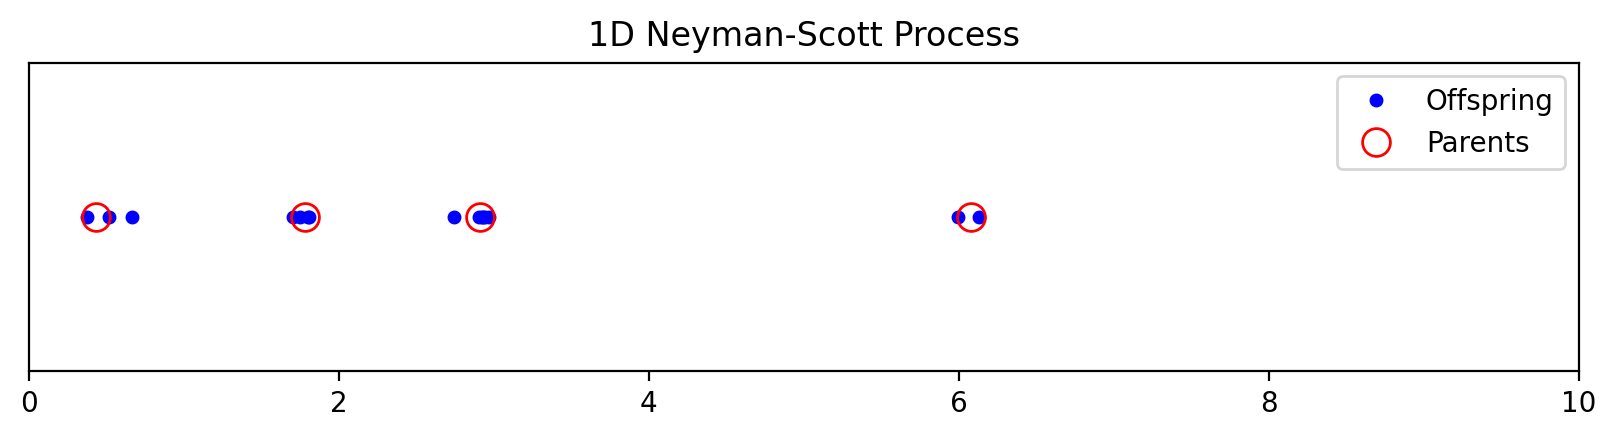

In [4]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

def simulate_1d_neyman_scott(lambda_p, mu_c, sigma, L):
    # 1. Generate parent points
    num_parents = np.random.poisson(lambda_p * L)
    parent_points = np.random.uniform(0, L, num_parents)
    
    offspring_points = []
    
    # 2. For each parent, generate offspring
    for parent in parent_points:
        num_offspring = np.random.poisson(mu_c)
        displacements = np.random.normal(0, sigma, num_offspring)
        offspring = parent + displacements
        offspring_points.append(offspring)
    
    # Flatten list
    offspring_points = np.concatenate(offspring_points)
    
    return offspring_points, parent_points

# Parameters
lambda_p = 0.5    # parent density per unit length
mu_c = 5          # mean number of offspring per parent
sigma = 0.1       # spread of offspring
L = 10            # total length of the line

# Simulate
offspring_points, parent_points = simulate_1d_neyman_scott(lambda_p, mu_c, sigma, L)

# Plot
plt.figure(figsize=(10, 2))
plt.plot(offspring_points, np.zeros_like(offspring_points), 'b.', label='Offspring', markersize=8)
plt.plot(parent_points, np.zeros_like(parent_points), 'ro', label='Parents', markersize=10, markerfacecolor='none')
plt.yticks([])
plt.xlim(0, L)
plt.legend()
plt.title('1D Neyman-Scott Process')
plt.show()

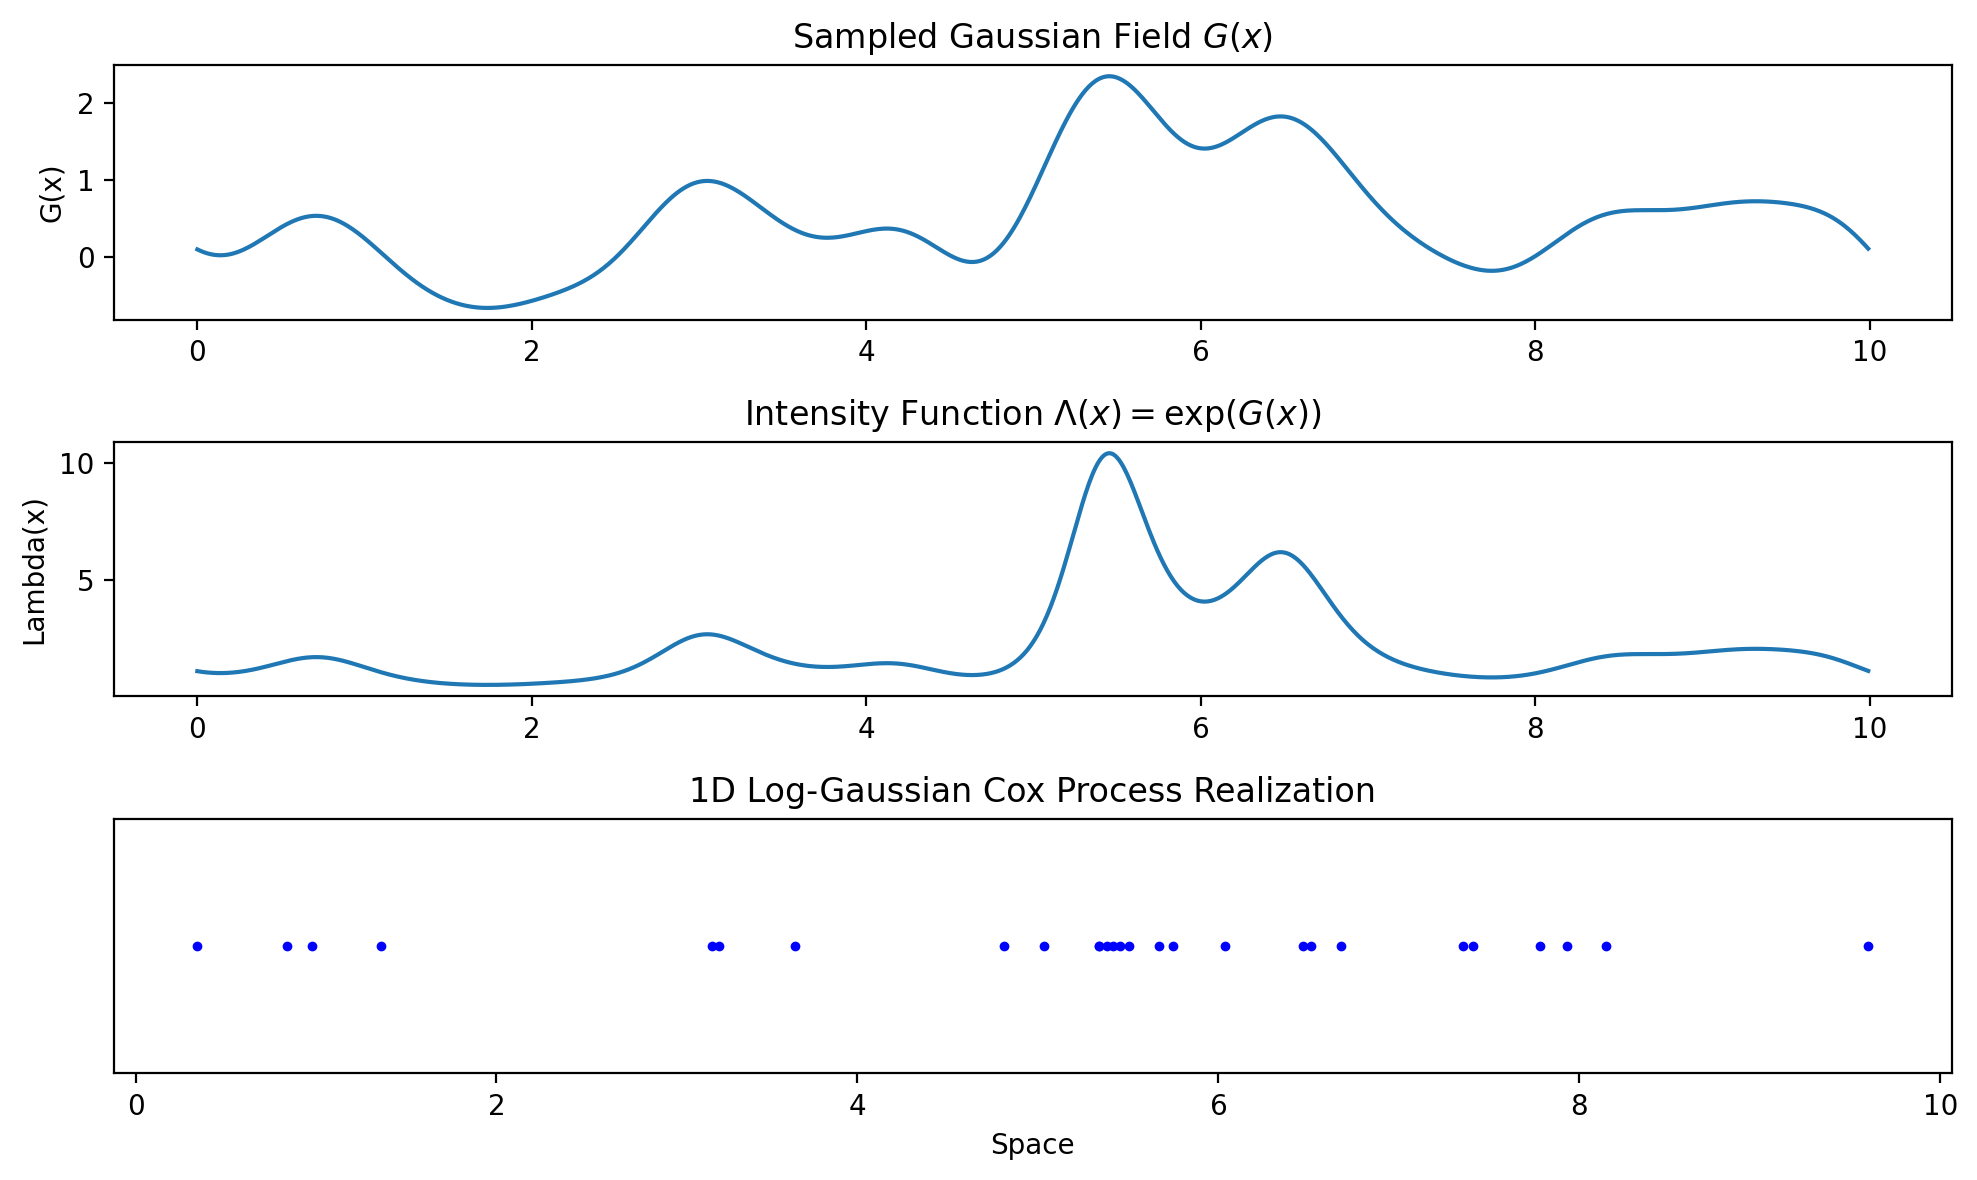

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def simulate_1d_lgcp(L, dx, mean_log_intensity, variance, length_scale):
    # Discretize space
    x = np.arange(0, L, dx)
    n = len(x)
    
    # Compute covariance matrix (Squared Exponential Kernel)
    dists = cdist(x[:, None], x[:, None], metric='euclidean')
    K = variance * np.exp(-0.5 * (dists / length_scale)**2)
    
    # Sample from multivariate normal (Gaussian Process)
    mean_vector = mean_log_intensity * np.ones(n)
    G = np.random.multivariate_normal(mean_vector, K)
    
    # Exponentiate to get positive intensities
    Lambda = np.exp(G)
    
    # Now simulate Poisson points
    points = []
    for xi, lam in zip(x, Lambda):
        expected_points = lam * dx
        num_points = np.random.poisson(expected_points)
        points.extend(xi + dx * np.random.rand(num_points))
    
    return np.array(points), x, Lambda, G

# Parameters
L = 10             # Length of domain
dx = 0.01          # Bin width
mean_log_intensity = 1.0  # Mean of log-intensity
variance = 1.0     # Variance of the Gaussian Process
length_scale = 0.5 # Length scale of covariance

# Simulate
points, x, Lambda, G = simulate_1d_lgcp(L, dx, mean_log_intensity, variance, length_scale)

# Plot
plt.figure(figsize=(10, 6))

plt.subplot(3,1,1)
plt.plot(x, G)
plt.title('Sampled Gaussian Field $G(x)$')
plt.ylabel('G(x)')

plt.subplot(3,1,2)
plt.plot(x, Lambda)
plt.title(r'Intensity Function $\Lambda(x) = \exp(G(x))$')
plt.ylabel('Lambda(x)')

plt.subplot(3,1,3)
plt.plot(points, np.zeros_like(points), 'b.', markersize=5)
plt.title('1D Log-Gaussian Cox Process Realization')
plt.yticks([])
plt.xlabel('Space')

plt.tight_layout()
plt.show()

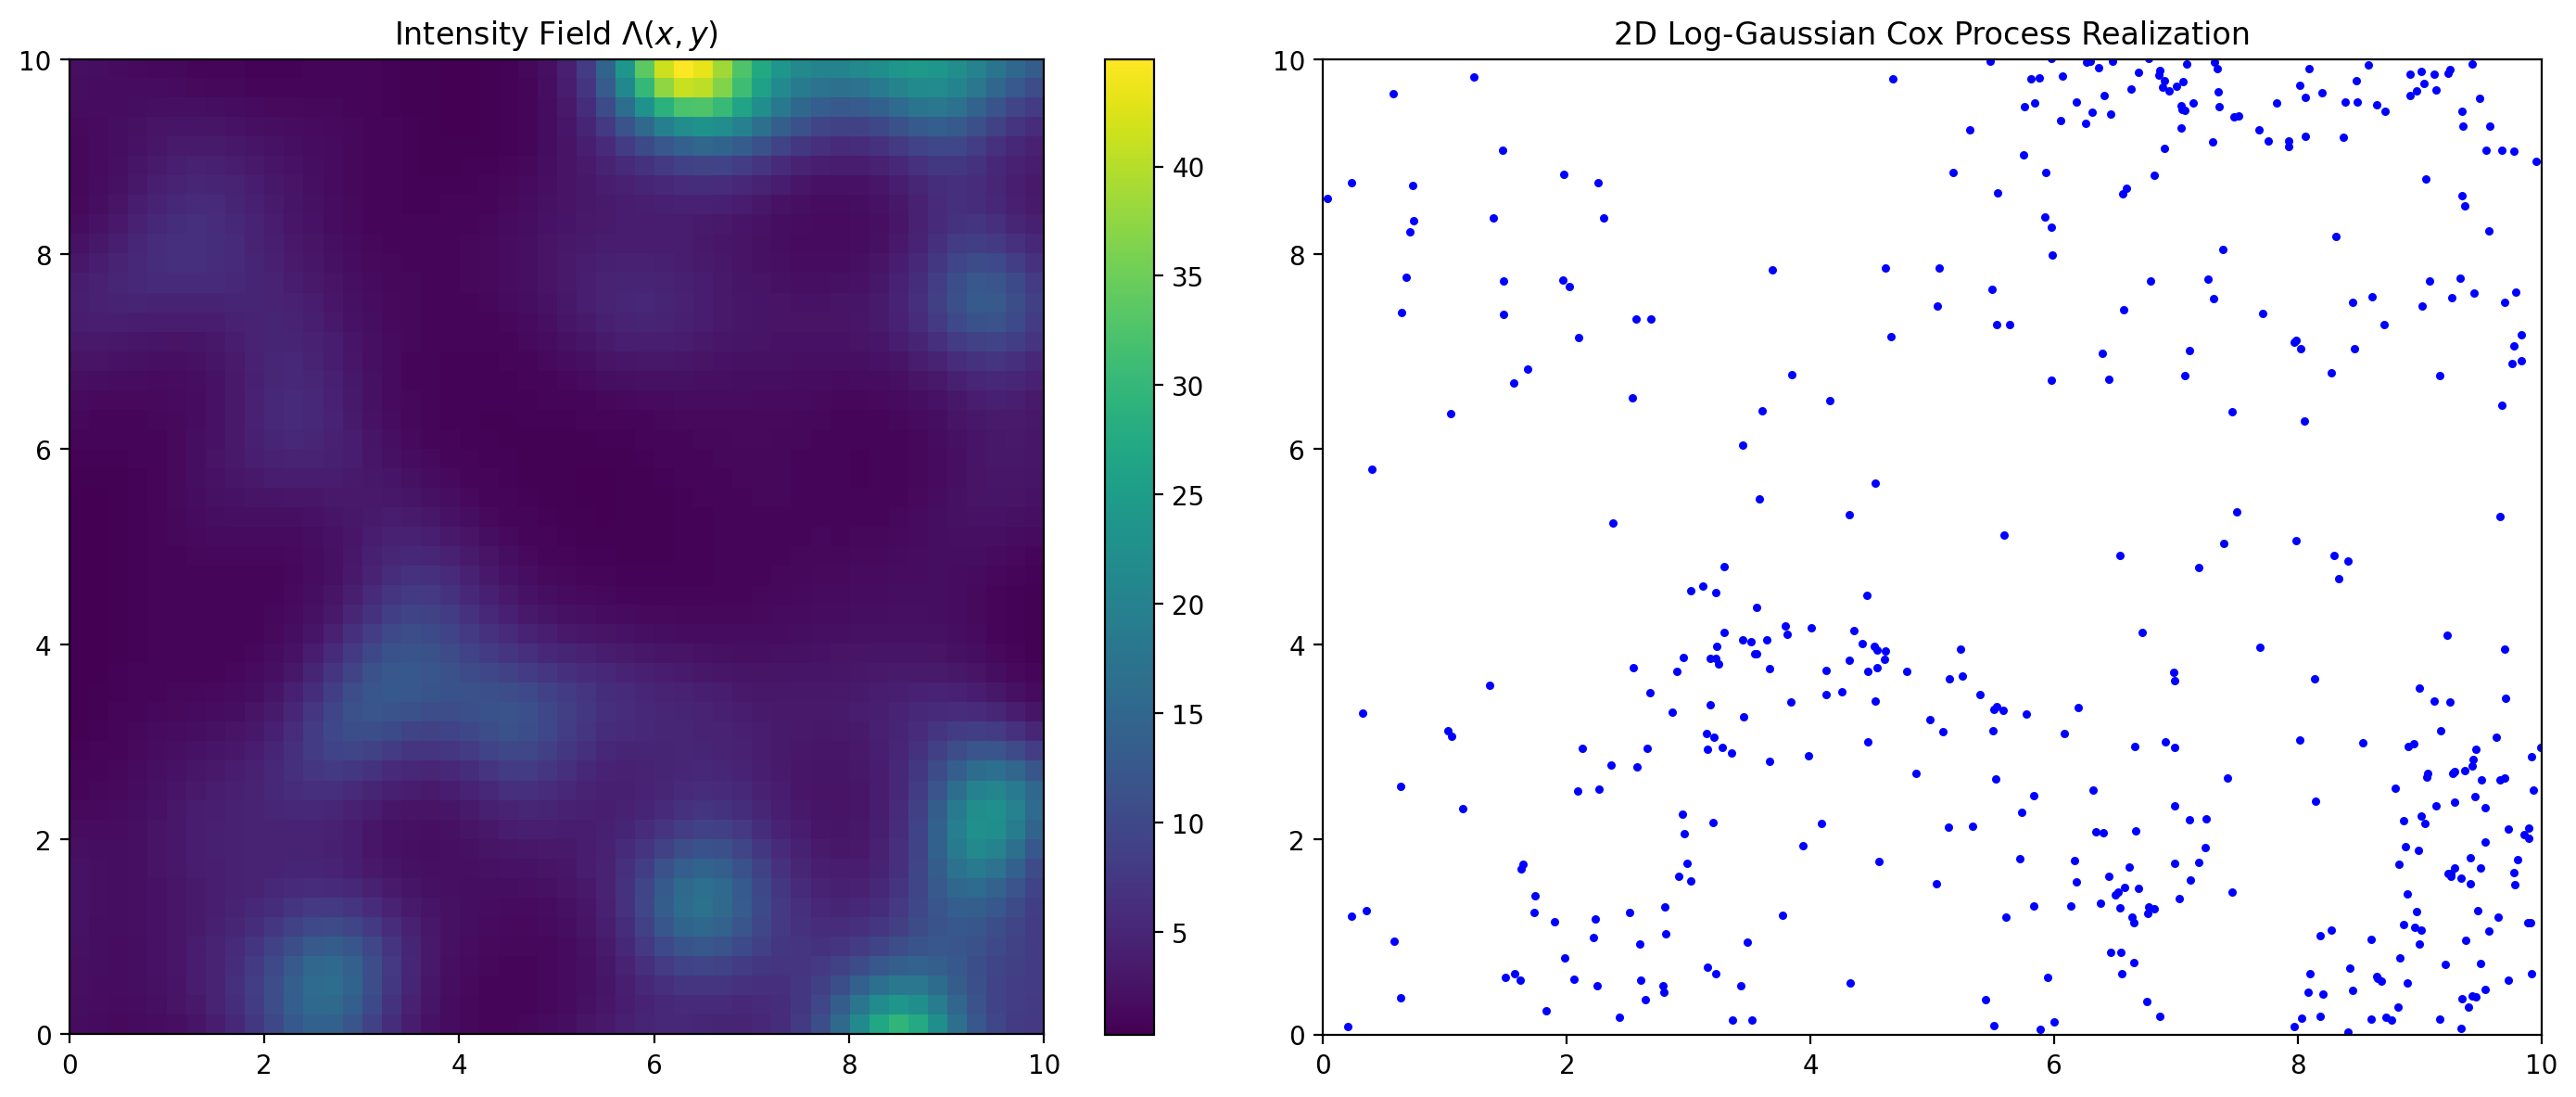

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def simulate_2d_lgcp(domain_size, grid_size, mean_log_intensity, variance, length_scale):
    # Create grid
    x = np.linspace(0, domain_size, grid_size)
    y = np.linspace(0, domain_size, grid_size)
    xx, yy = np.meshgrid(x, y)
    coords = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Compute covariance matrix (Squared Exponential Kernel)
    dists = cdist(coords, coords, metric='euclidean')
    K = variance * np.exp(-0.5 * (dists / length_scale)**2)
    
    # Sample from multivariate normal (Gaussian process)
    mean_vector = mean_log_intensity * np.ones(len(coords))
    G = np.random.multivariate_normal(mean_vector, K)
    
    # Exponentiate to get intensity
    Lambda = np.exp(G).reshape(grid_size, grid_size)
    
    # Simulate points
    dx = domain_size / grid_size
    points = []
    for i in range(grid_size):
        for j in range(grid_size):
            lam = Lambda[i, j]
            expected_points = lam * dx * dx
            num_points = np.random.poisson(expected_points)
            # Uniformly distribute points within the cell
            for _ in range(num_points):
                px = x[j] + dx * np.random.rand()
                py = y[i] + dx * np.random.rand()
                points.append((px, py))
    
    return np.array(points), x, y, Lambda

# Parameters
domain_size = 10          # Size of square domain
grid_size = 50            # Discretization resolution
mean_log_intensity = 1.0  # Mean of log-intensity field
variance = 1.0            # Variance of Gaussian field
length_scale = 1.0        # Correlation length scale

# Simulate 2D LGCP
points, x, y, Lambda = simulate_2d_lgcp(domain_size, grid_size, mean_log_intensity, variance, length_scale)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the intensity field
im = ax[0].imshow(Lambda, extent=(0, domain_size, 0, domain_size), origin='lower', cmap='viridis')
ax[0].set_title(r"Intensity Field $\Lambda(x,y)$")
fig.colorbar(im, ax=ax[0])

# Plot the point realization
ax[1].scatter(points[:, 0], points[:, 1], s=5, color='blue')
ax[1].set_xlim(0, domain_size)
ax[1].set_ylim(0, domain_size)
ax[1].set_title("2D Log-Gaussian Cox Process Realization")

plt.tight_layout()
plt.show()

In [35]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

def get_poisson_process_samples(rate):
    """
    Generate sample data where the number of samples are Poisson distributed 
    and the values are uniformly distributed on [0,1].
    """
    s = np.random.poisson(rate)
    return np.random.rand(s)

def neyman_scott_process(lambda_p, lambda_c, sigma):
    """
    Simulate a Neyman-Scott process in 1D.
    
    Parameters:
    - lambda_p: Intensity of parent points (mean number of parents per unit length)
    - mu_c: Mean number of offspring per parent
    - sigma: Standard deviation of the normal distribution for offspring displacement
    - L: Length of the domain
    
    Returns:
    - offspring_points: Array of offspring points
    - parent_points: Array of parent points
    """
    # 1. Generate parent points
    num_parents = np.random.poisson(lambda_p)
    parent_points = np.random.uniform(0, 1, num_parents)
    
    offspring_points = []
    
    # 2. For each parent, generate offspring
    for parent in parent_points:
        num_offspring = np.random.poisson(lambda_c)
        displacements = np.random.normal(0, sigma, num_offspring)
        offspring = parent + displacements
        offspring_points.append(offspring)
    
    # Combine all points into a single array
    return np.concatenate((np.concatenate(offspring_points), parent_points))
    

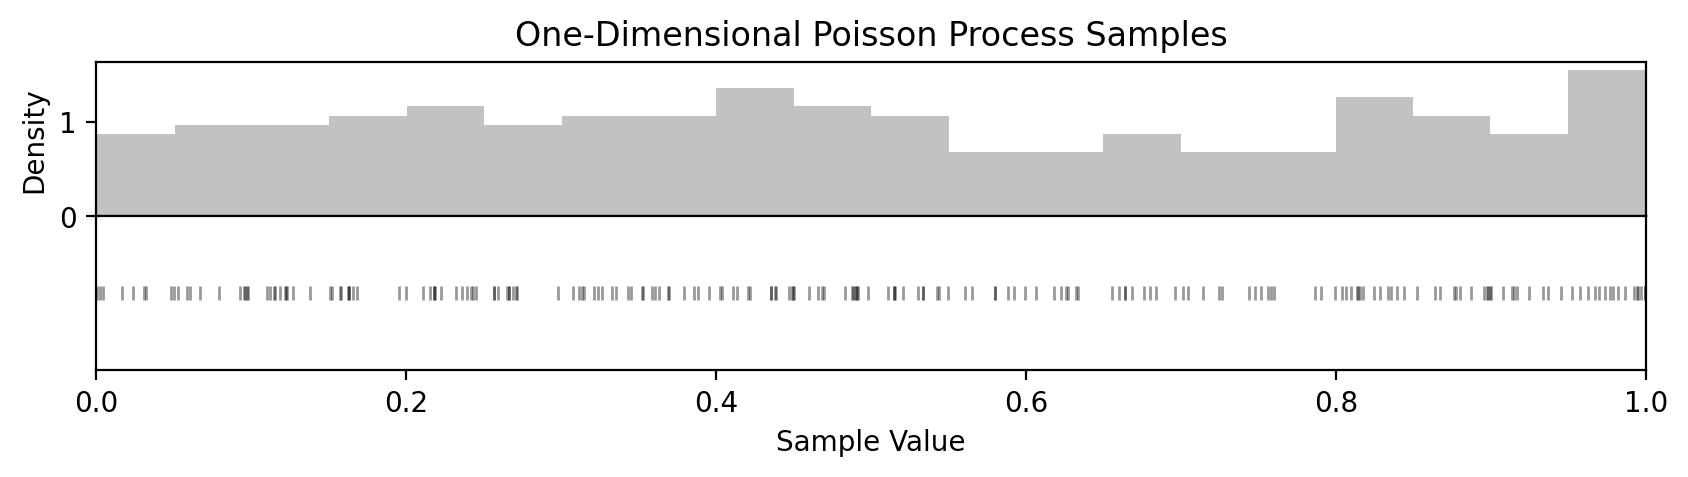

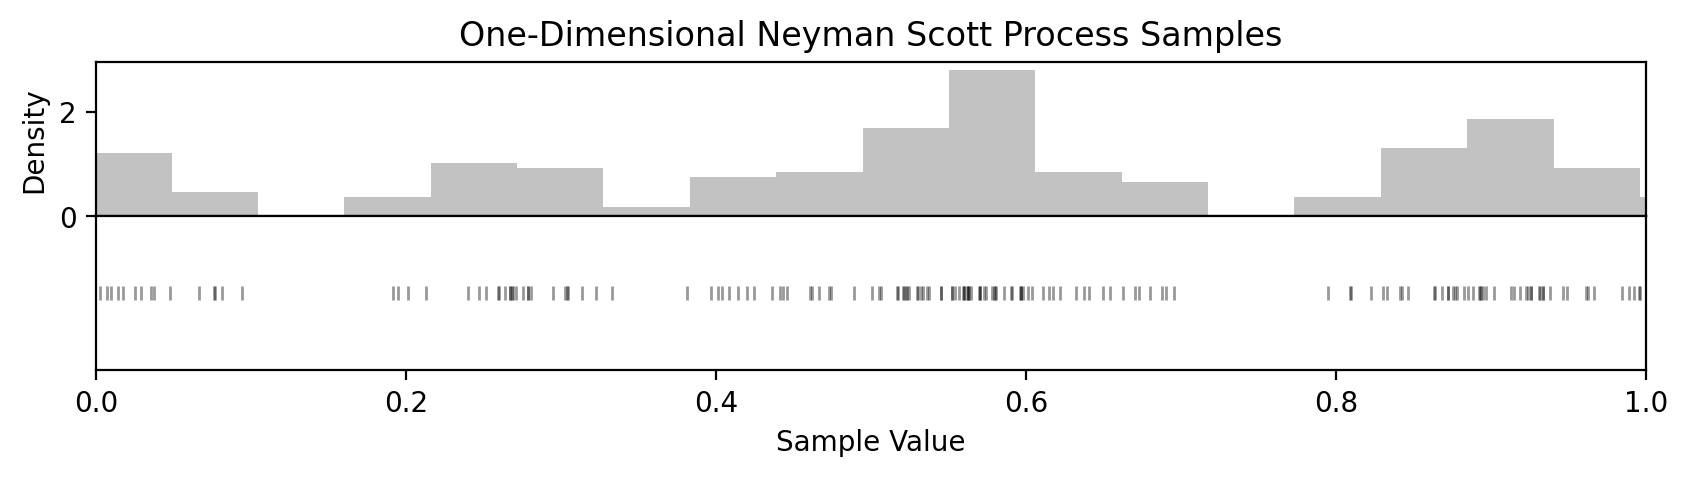

In [38]:

def plot_one_d_samples(samples, title):
    """
    Plot one-dimensional samples.
    """
    fig, ax = plt.subplots(2,1,figsize=(10, 2), gridspec_kw={'height_ratios': [1, 1]})
    
    # Add a histogram to visualize the distribution of samples
    ax[0].hist(samples, bins=20, density=True, alpha=0.7, color='darkgrey')
    ax[0].set(
        title=title,
        xlabel='Sample Value',
        ylabel='Density',
        xlim=(0, 1),
        xticks=[],
    )
    
    # Plot the samples as vertical lines
    ax[1].plot(samples, np.zeros_like(samples), 
               marker='|',
               color='black',
               markersize=5,
               linestyle='None',
               alpha=0.4)
    ax[1].set(
        yticks=[],
        xlim=(0, 1),
        xlabel='Sample Value'
    )
    
    plt.subplots_adjust(hspace=0)


# Generate samples from a one-dimensional Poisson process
N = 200
lambda_p = 10
lambda_c = N / lambda_p
sigma = 0.05
data = {}
data['poisson'] = get_poisson_process_samples(N)
data['neyman-scott'] = neyman_scott_process(lambda_p, lambda_c, sigma)

# Plot the one-dimensional Poisson process samples
plot_one_d_samples(data['poisson'], 'One-Dimensional Poisson Process Samples')
plot_one_d_samples(data['neyman-scott'], 'One-Dimensional Neyman Scott Process Samples')